In [3]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


# Provincial Predictions

[0. 0. 0. 0. 0. 0. 0. 0.]
20.824654416700188
[0. 0. 0. 0. 0. 0. 0. 0.]
20.935526465094394
[ 0.          0.70083026  0.13972444  0.00120039  0.11295568 -0.23297473
 -0.10949484  0.34246957 -0.88964941  0.38933485  0.04356451]
9.136409569930475
[ 0.          0.65909821  0.11599782 -0.00164234  0.23092288 -0.25793681
 -0.10256076  0.36049756 -1.02642462  0.40188008  0.10773591]
8.754530936039503
[ 3.85148576e-09 -7.20901581e-12  5.00693149e-06  2.10927849e-09
  3.72310290e-09  3.85148576e-10  9.87327007e-11  1.48994650e-11]
20.839512228704038
[ 1.79123246e-08 -3.35273812e-11  2.32860220e-05  9.80974186e-09
  1.73152471e-08  1.79123246e-09  4.59181806e-10  6.92937923e-11]
21.00462653927419
[ 0.04872622  0.32933408 -0.13049202  0.01697755  0.67645703 -0.09968655
 -0.04060732  0.14029388 -0.30057443  0.1115242   0.20904968]
-90.54854638601056
[ 0.03940555  0.37878202 -0.13820985  0.01182719  0.71518313 -0.12761674
 -0.05408539  0.18170213 -0.48041182  0.13706637  0.23448821]
-72.295630009580

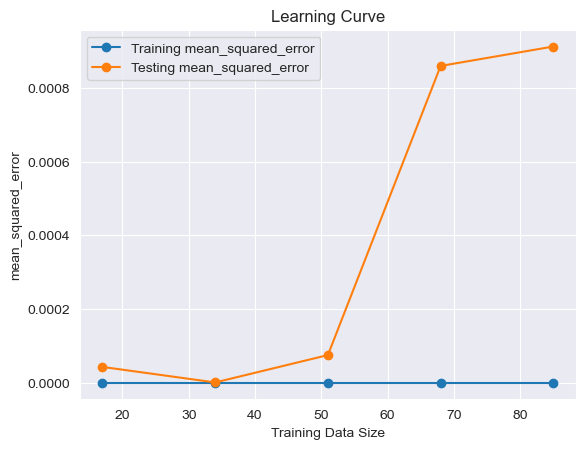

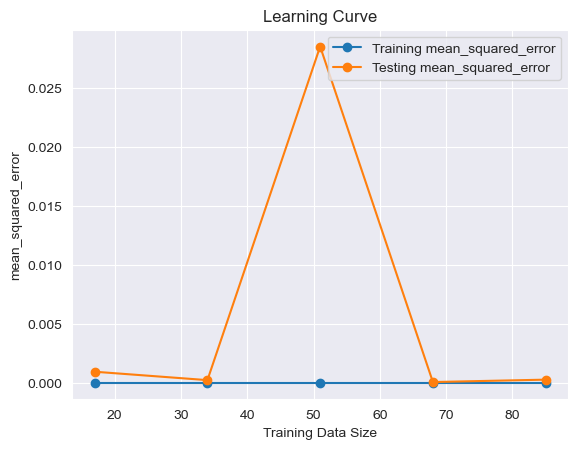

In [4]:
# model 1
next_year_total_predictor = {
    "models": {
        "Next Year Total Expenses": LinearRegression(),
        "Next Year Total Revenues": LinearRegression(),
    },
    "features": {
        "x": [
            "Year",
            "Population",
            "Population Change",
            "GDP",
            "Inflation",
            "Minimum Wage",
            "Total Expenses",
            "Total Revenues",
        ],
        "y": [
            "Next Year Total Expenses",
            "Next Year Total Revenues"
        ],
        "log": [
            "Population",
            "Total Expenses",
            "Total Revenues",
            "Next Year Total Expenses",
            "Next Year Total Revenues",
        ]
    },
    "scores": {
        "Next Year Total Expenses": {
            "train": {
                "train data size": [],
                "mse": []
            },
            "test": {
                "train data size": [],
                "mse": []
            }},
        "Next Year Total Revenues": {
            "train": {
                "train data size": [],
                "mse": []
            },
            "test": {
                "train data size": [],
                "mse": []
            }}

    }
}

# model 2
next_year_county_predictor = {
    "models": {
        "Total Expenses": LinearRegression(),
        "Total Revenues": LinearRegression(),
    },
    "features": {
        "x": [
            "Year",
            "Population",
            "Population Change Percentage",
            "Population Density",
            "Land Area",
            "County",
            "District",
            "Regional",
            "Residential Tax Rates",
            "Commercial Tax Rates",
            "Population Size"
        ],
        "y": [
            "Next Year Total Expenses",
            "Next Year Total Revenues"
        ],
        "log": [
            "Population",
            "Land Area",
            "Total Expenses",
            "Total Revenues",
            "Next Year Total Expenses",
            "Next Year Total Revenues",
        ]
    },
    "scores": {
        "Total Expenses": {
            "train": {
                "train data size": [],
                "mse": []
            },
            "test": {
                "train data size": [],
                "mse": []
            }},
        "Total Revenues": {
            "train": {
                "train data size": [],
                "mse": []
            },
            "test": {
                "train data size": [],
                "mse": []
            }}

    }
}

# load data
data = pd.read_csv("../output/2-binning.csv")
data = data[data["Year"] < 2019]
data = data.sort_values(by="Year")

# Train-test split (using TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5, test_size=17)
for train_index, test_index in tscv.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # total 
    total_train_data = train_data.copy().groupby("Year").agg({
        "Population": "sum",
        "Population Change": "sum",
        "GDP": "mean",
        "Inflation": "mean",
        "Minimum Wage": "mean",
        "Total Expenses": "sum",
        "Total Revenues": "sum",
        "Next Year Total Expenses": "sum",
        "Next Year Total Revenues": "sum",
    }).reset_index()
    total_test_data = test_data.copy().groupby("Year").agg({
        "Population": "sum",
        "Population Change": "sum",
        "GDP": "mean",
        "Inflation": "mean",
        "Minimum Wage": "mean",
        "Total Expenses": "sum",
        "Total Revenues": "sum",
        "Next Year Total Expenses": "sum",
        "Next Year Total Revenues": "sum",
    }).reset_index()

    # county
    county_train_data = train_data.copy()
    county_test_data = test_data.copy()

    for feature in next_year_total_predictor["features"]["log"]:
        total_train_data[feature] = np.log(total_train_data[feature])
        total_test_data[feature] = np.log(total_test_data[feature])

    for feature in next_year_county_predictor["features"]["log"]:
        county_train_data[feature] = np.log(county_train_data[feature])
        county_test_data[feature] = np.log(county_test_data[feature])

    # training next total model
    for name, model in next_year_total_predictor["models"].items():
        X = total_train_data[next_year_total_predictor["features"]["x"]]
        y = total_train_data[name]
        model.fit(X, y)

        print(model.coef_)
        print(model.intercept_)
        
        y_pred = model.predict(X)
        y_actual = y
        
        mse = mean_squared_error(y_pred, y_actual)
        next_year_total_predictor["scores"][name]["train"]["train data size"].append(len(train_data))
        next_year_total_predictor["scores"][name]["train"]["mse"].append(mse)

    # training county model
    for name, model in next_year_county_predictor["models"].items():
        X = county_train_data[next_year_county_predictor["features"]["x"]]
        y = county_train_data[name]
        model.fit(X, y)

        print(model.coef_)
        print(model.intercept_)
        
        y_pred = model.predict(X)
        y_actual = y
        
        mse = mean_squared_error(y_pred, y_actual)
        next_year_county_predictor["scores"][name]["train"]["train data size"].append(len(train_data))
        next_year_county_predictor["scores"][name]["train"]["mse"].append(mse)

    # testing next total model
    for name, model in next_year_total_predictor["models"].items():
        y_pred = model.predict(total_test_data[next_year_total_predictor["features"]["x"]])
        y_actual = total_test_data[name].to_numpy()

        mse = mean_squared_error(y_pred, y_actual)
        next_year_total_predictor["scores"][name]["test"]["train data size"].append(len(train_data))
        next_year_total_predictor["scores"][name]["test"]["mse"].append(mse)

    # testing county model
    for name, model in next_year_county_predictor["models"].items():
        y_pred = model.predict(county_test_data[next_year_county_predictor["features"]["x"]])
        y_actual = county_test_data[name].to_numpy()

        mse = mean_squared_error(y_pred, y_actual)
        next_year_county_predictor["scores"][name]["test"]["train data size"].append(len(train_data))
        next_year_county_predictor["scores"][name]["test"]["mse"].append(mse)

# Learning Curve

plt.plot(next_year_total_predictor["scores"]["Next Year Total Expenses"]["train"]["train data size"],
         next_year_total_predictor["scores"]["Next Year Total Expenses"]["train"]["mse"], 'o-', label='Training ' + mean_squared_error.__name__)
plt.plot(next_year_total_predictor["scores"]["Next Year Total Expenses"]["test"]["train data size"],
         next_year_total_predictor["scores"]["Next Year Total Expenses"]["test"]["mse"], 'o-', label='Testing ' + mean_squared_error.__name__)
plt.xlabel('Training Data Size')
plt.ylabel(mean_squared_error.__name__)
plt.title('Learning Curve')
plt.legend()
plt.show()

plt.plot(next_year_total_predictor["scores"]["Next Year Total Revenues"]["train"]["train data size"],
         next_year_total_predictor["scores"]["Next Year Total Revenues"]["train"]["mse"], 'o-', label='Training ' + mean_squared_error.__name__)
plt.plot(next_year_total_predictor["scores"]["Next Year Total Revenues"]["test"]["train data size"],
         next_year_total_predictor["scores"]["Next Year Total Revenues"]["test"]["mse"], 'o-', label='Testing ' + mean_squared_error.__name__)
plt.xlabel('Training Data Size')
plt.ylabel(mean_squared_error.__name__)
plt.title('Learning Curve')
plt.legend()
plt.show()

# Fitted Model

In [5]:
coef = next_year_total_predictor["models"]["Next Year Total Revenues"].coef_
bias = next_year_total_predictor["models"]["Next Year Total Expenses"].intercept_
features_x = next_year_total_predictor["features"]["x"]

print(features_x)
coef
bias

['Year', 'Population', 'Population Change', 'GDP', 'Inflation', 'Minimum Wage', 'Total Expenses', 'Total Revenues']


-2.7857861545148275

In [6]:
coef = next_year_county_predictor["models"]["Total Expenses"].coef_
bias = next_year_county_predictor["models"]["Total Expenses"].intercept_
features_x = next_year_county_predictor["features"]["x"]

print(features_x)
coef
bias

['Year', 'Population', 'Population Change Percentage', 'Population Density', 'Land Area', 'County', 'District', 'Regional', 'Residential Tax Rates', 'Commercial Tax Rates', 'Population Size']


-61.57163200942048

# Model

In [7]:
def next_year_total_predictions(curr_data: pd.DataFrame):
    curr_data = curr_data.copy().groupby("Year").agg({
        "Population": "sum",
        "Population Change": "sum",
        "GDP": "mean",
        "Inflation": "mean",
        "Minimum Wage": "mean",
        "Total Expenses": "sum",
        "Total Revenues": "sum",
    }).reset_index()

    for f in next_year_total_predictor["features"]["log"]:
        if f not in ["Next Year Total Expenses", "Next Year Total Revenues"]:
            curr_data[f] = np.log(curr_data[f])

    predictions = {}
    for n, m in next_year_total_predictor["models"].items():
        predictions[n] = np.exp(m.predict(curr_data[next_year_total_predictor["features"]["x"]]))

    return predictions


def next_year_county_predictions(curr_data: pd.DataFrame):
    curr_data = curr_data.copy()
    for f in next_year_county_predictor["features"]["log"]:
        curr_data[f] = np.log(curr_data[f])

    predictions = curr_data
    for n, m in next_year_county_predictor["models"].items():
        predictions["Predicted Next Year " + n] = np.exp(
            m.predict(curr_data[next_year_county_predictor["features"]["x"]])).astype(np.int64)

    return predictions[["Region", "Predicted Next Year Total Expenses", "Predicted Next Year Total Revenues"]]

## Evaluation on year 2020

In [8]:
data = pd.read_csv("../output/2-binning.csv")
data = data.sort_values(by="Year")

predictions = next_year_total_predictions(data[data["Year"] == 2019])

total_expenses_2020 = data[data["Year"] == 2020]["Total Expenses"].sum()
total_revenues_2020 = data[data["Year"] == 2020]["Total Revenues"].sum()

print("Predicted", predictions)
print("Actual", total_expenses_2020)
print("Actual", total_revenues_2020)

Predicted {'Next Year Total Expenses': array([1.21254185e+09]), 'Next Year Total Revenues': array([1.40890686e+09])}
Actual 1230868649
Actual 1467053121


In [9]:
print("Expenses Percentage Difference",
      ((predictions["Next Year Total Expenses"] - total_expenses_2020) / total_expenses_2020) * 100
      )
print("Revenues Percentage Difference",
      ((predictions["Next Year Total Revenues"] - total_expenses_2020) / total_revenues_2020) * 100
      )

Expenses Percentage Difference [-1.48893227]
Revenues Percentage Difference [12.13577148]


In [10]:
data = pd.read_csv("../output/2-binning.csv")
data = data.sort_values(by="Year")

predictions = next_year_county_predictions(data[data["Year"] == 2019])

predictions

,Region,Predicted Next Year Total Expenses,Predicted Next Year Total Revenues
14,Antigonish,15245080,16554337
110,Richmond,9500310,10490969
118,Shelburne,17326148,19121731
126,Victoria,9088064,9859349
6,Annapolis,19310326,21117290
30,Colchester,49292591,57379208
38,Cumberland,35681794,41731339
78,Inverness,20612907,23565834
22,Cape Breton,124262886,135008891
86,Kings,56816271,63724983


In [11]:
county_data_2020 = data[data["Year"] == 2020][["Year", "Region", "Total Expenses", "Total Revenues"]]
print("Actual")
county_data_2020

Actual


,Year,Region,Total Expenses,Total Revenues
47,2020,Digby,16891255,18960166
55,2020,Guysborough,16100548,19282783
63,2020,Halifax,708955527,865285000
127,2020,Victoria,8786747,10256693
71,2020,Hants,43095201,49575049
23,2020,Cape Breton,126935138,142219006
79,2020,Inverness,12735592,13697179
39,2020,Cumberland,37128393,42627666
119,2020,Shelburne,17512846,18904460
87,2020,Kings,56289133,63438378


In [12]:
res = county_data_2020.merge(predictions, on="Region")
res["%age Error Expenses"] = np.absolute((res["Total Expenses"] - res["Predicted Next Year Total Expenses"]) / res[
    "Total Expenses"]) * 100
res["%age Error Revenues"] = np.absolute((res["Total Revenues"] - res["Predicted Next Year Total Revenues"]) / res[
    "Total Revenues"]) * 100
res

,Year,Region,Total Expenses,Total Revenues,Predicted Next Year Total Expenses,Predicted Next Year Total Revenues,%age Error Expenses,%age Error Revenues
0,2020,Digby,16891255,18960166,17831784,19967483,5.568142,5.312807
1,2020,Guysborough,16100548,19282783,16287551,19749532,1.161470,2.420548
2,2020,Halifax,708955527,865285000,715513794,822086748,0.925060,4.992373
3,2020,Victoria,8786747,10256693,9088064,9859349,3.429221,3.873997
4,2020,Hants,43095201,49575049,42554226,50468476,1.255302,1.802171
5,2020,Cape Breton,126935138,142219006,124262886,135008891,2.105211,5.069727
6,2020,Inverness,12735592,13697179,20612907,23565834,61.852759,72.048814
7,2020,Cumberland,37128393,42627666,35681794,41731339,3.896207,2.102688
8,2020,Shelburne,17512846,18904460,17326148,19121731,1.066063,1.149311
9,2020,Kings,56289133,63438378,56816271,63724983,0.936483,0.451785


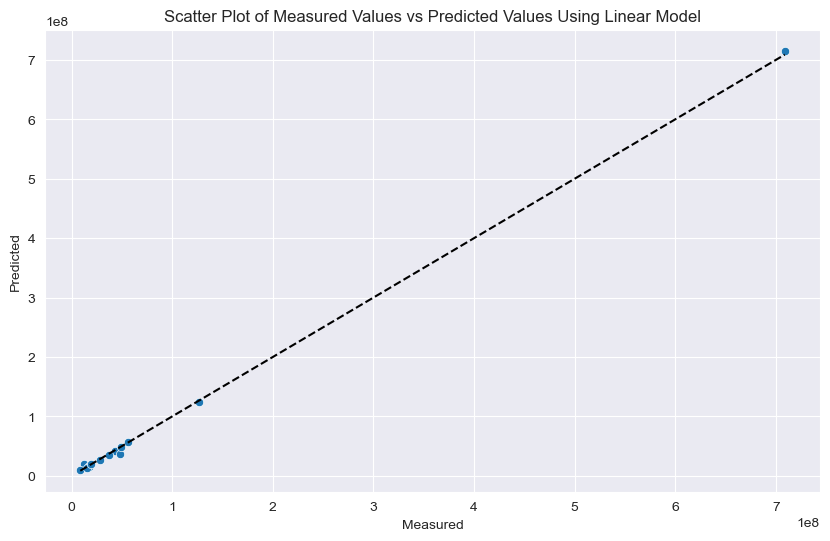

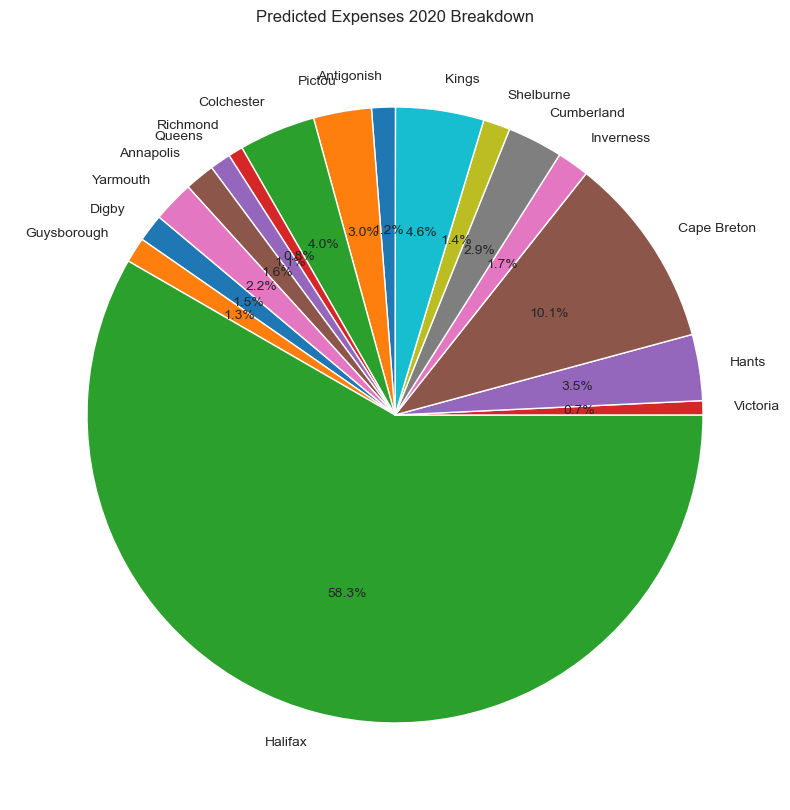

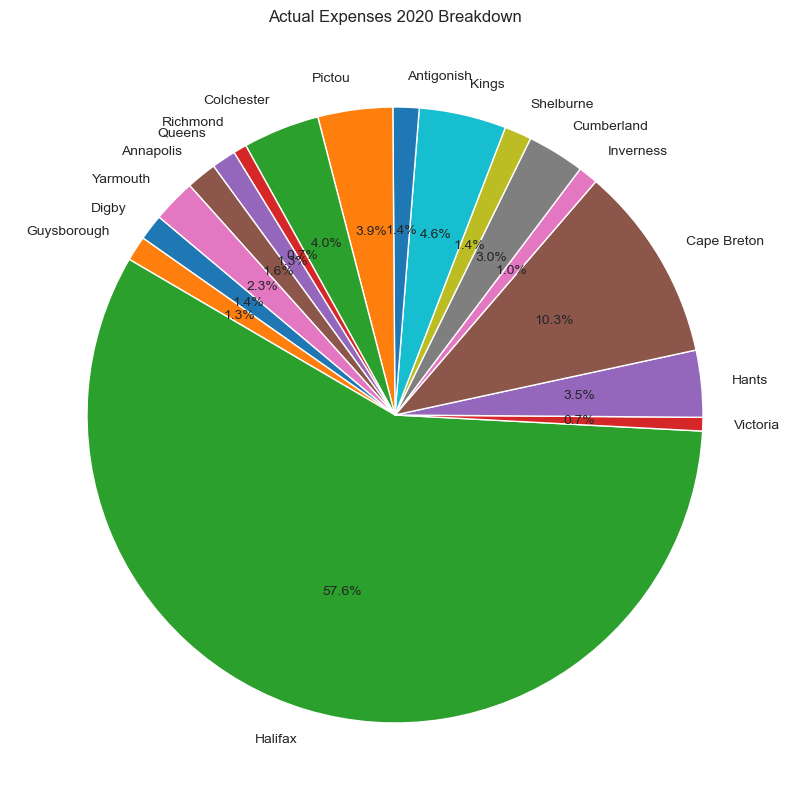

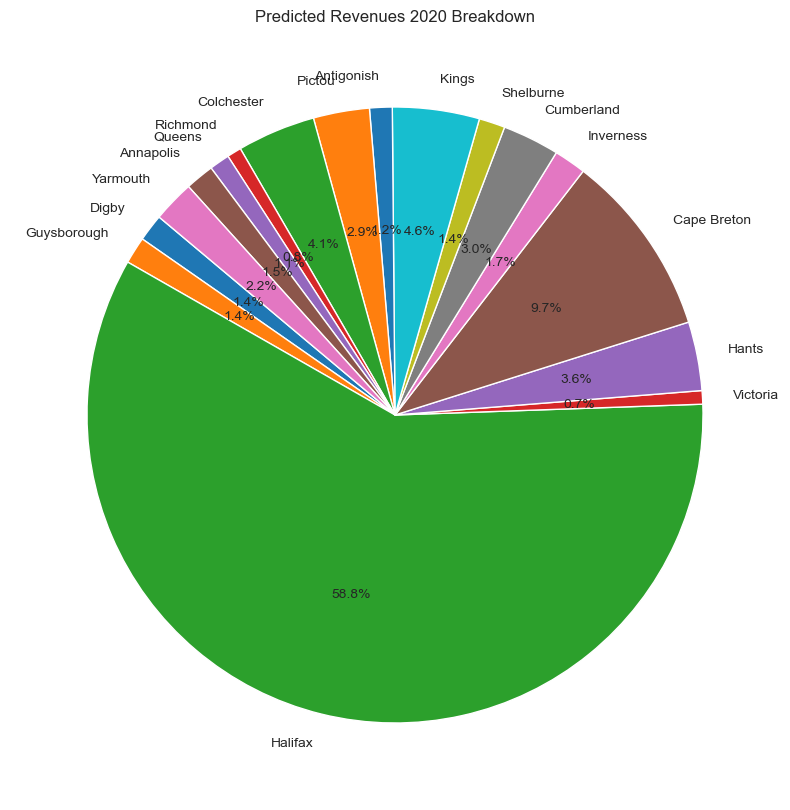

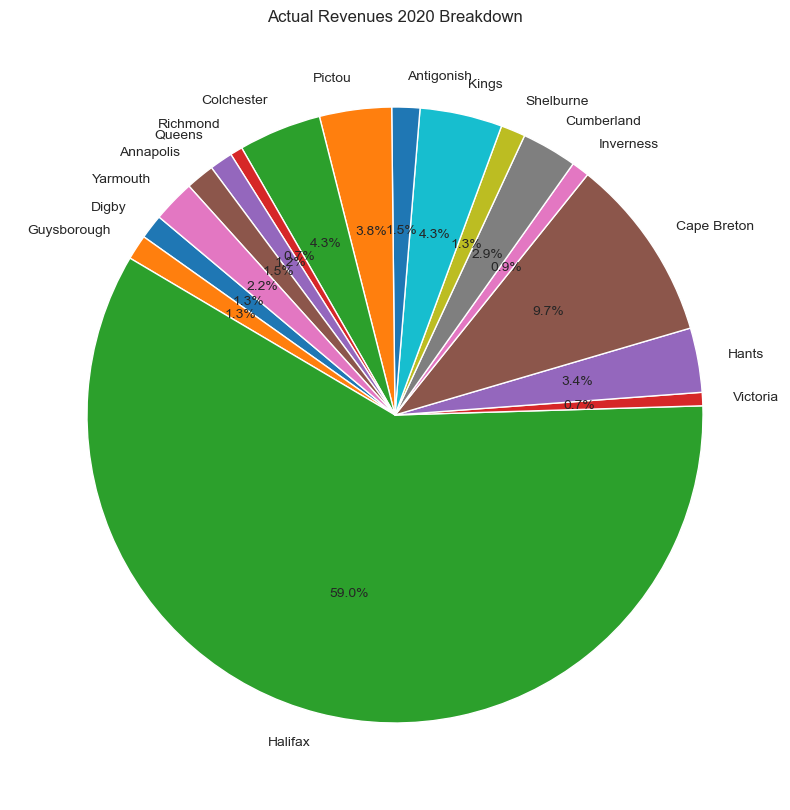

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = res["Predicted Next Year Total Expenses"]
y_test = res["Total Expenses"]

# 1. Scatter Plot with Best Fit Line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color = 'black')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Scatter Plot of Measured Values vs Predicted Values Using Linear Model')
plt.show()

plt.figure(figsize=(10, 10)) 
plt.pie(res["Predicted Next Year Total Expenses"], labels=res["Region"], autopct='%1.1f%%', startangle=140)
plt.title('Predicted Expenses 2020 Breakdown')
plt.show()

plt.figure(figsize=(10, 10)) 
plt.pie(res["Total Expenses"], labels=res["Region"], autopct='%1.1f%%', startangle=140)
plt.title('Actual Expenses 2020 Breakdown')
plt.show()

plt.figure(figsize=(10, 10)) 
plt.pie(res["Predicted Next Year Total Revenues"], labels=res["Region"], autopct='%1.1f%%', startangle=140)
plt.title('Predicted Revenues 2020 Breakdown')
plt.show()

plt.figure(figsize=(10, 10)) 
plt.pie(res["Total Revenues"], labels=res["Region"], autopct='%1.1f%%', startangle=140)
plt.title('Actual Revenues 2020 Breakdown')
plt.show()

In [14]:
math.sqrt(mean_squared_error(res["Total Expenses"], res["Predicted Next Year Total Expenses"]))

3805472.45385094

In [15]:
math.sqrt(mean_squared_error(res["Total Revenues"], res["Predicted Next Year Total Revenues"]))


11637542.69279577

# Prediction on year 2021

In [16]:
data = pd.read_csv("../output/2-binning.csv")
data = data.sort_values(by="Year")

print("Predicted", next_year_total_predictions(data[data["Year"] == 2020]))

Predicted {'Next Year Total Expenses': array([1.15909495e+09]), 'Next Year Total Revenues': array([1.39557281e+09])}


In [17]:
data = pd.read_csv("../output/2-binning.csv")
data = data[data["Year"] == 2020]

total_pop = data["Population"].sum()

np.mean((data["Total Expenses"] * data["Population"]) / total_pop)
np.mean(data["Total Expenses"])

72404038.1764706

In [18]:
data = pd.read_csv("../output/2-binning.csv")
data = data[data["Year"] == 2020]

data["Total Expenses"].sum()

1230868649